This project is written to create a complete system that detects faces from a camera, tracks emotion changes, saves the image when an emotion change occurs, and identifies the emotion using a machine learning model trained on the FER2013 dataset.

### Step 1: Intsall requrements libraries, modelues and etc.

In [36]:
import numpy as np
import cv2
import os
import pandas as pd
import glob


from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model


### Step 2: Load and Preprocess the FER2013 Dataset

In [2]:
# the link for loading data set https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge/data

In [6]:
df = pd.read_csv('../py_files/data/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

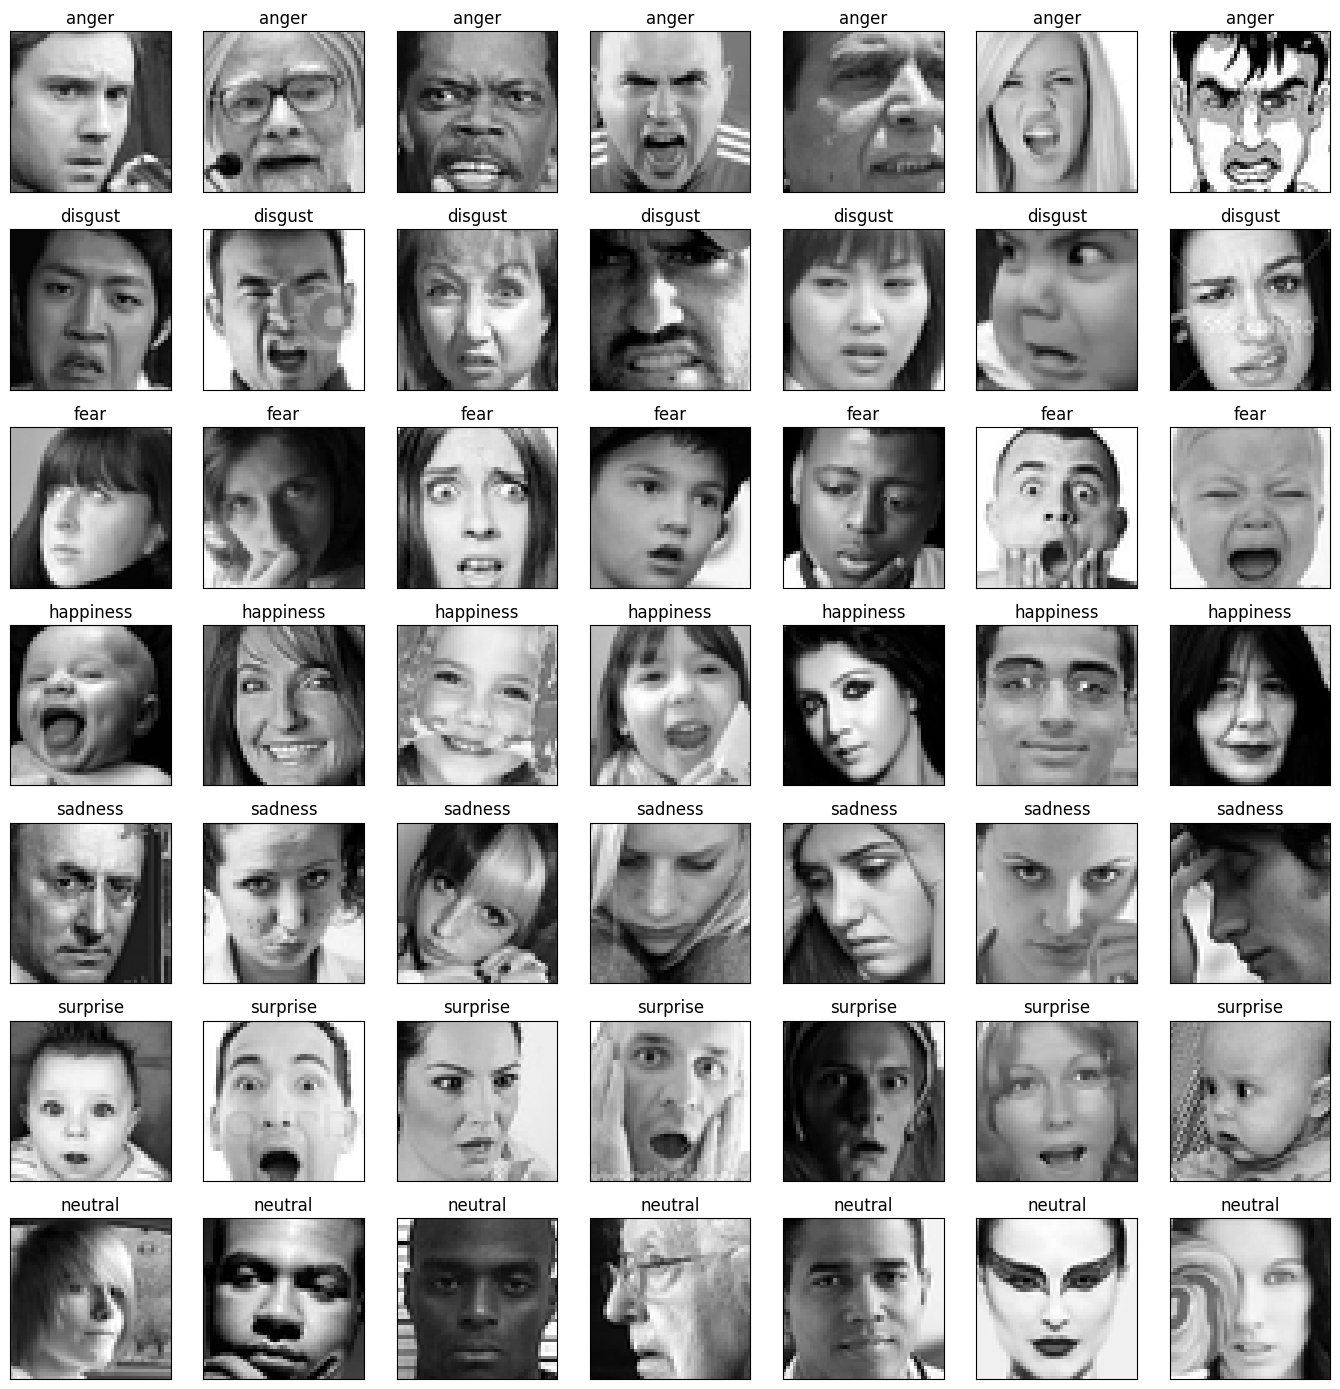

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [11]:
df.shape

(35887, 3)

In [12]:
# Convert the encoded labels to one-hot encoded format
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [13]:
img_labels[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [14]:
# Create a mapping from original class labels to their encoded values
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [15]:
# Converting a DataFrame column containing image data into a 3D numpy array

# This lambda function takes a string representation of pixel values, splits it into a list of strings, 
# converts each string to a float, and then reshapes the list into a 48x48x1 numpy array.
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

# Stack the 2D arrays (images) into a single 3D array.
img_array = np.stack(img_array, axis=0)

# https://numpy.org/doc/1.13/reference/generated/numpy.dstack.html

In [16]:
img_array.shape

(35887, 48, 48, 1)

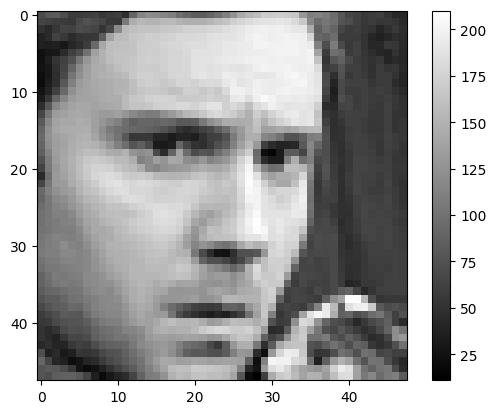

In [17]:
# Display, for example, the first image
image_to_display = img_array[0]

pyplot.imshow(image_to_display, cmap='gray')
pyplot.colorbar()
pyplot.show()

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle = True, stratify = img_labels,
                                                    test_size = 0.2, random_state = 42)

In [19]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [21]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

### Step 3: Define and Train the Model
Define a CNN model for emotion detection and train it on the FER2013 dataset.

In [20]:
def create_cnn_model(input_shape = (48, 48, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(512, (3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2), strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))


    model.add(Dense(7, activation = 'softmax')) # 7 emotions
    return model


In [21]:
# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

model.summary()


/home/alexander/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-28 11:29:56.204679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 11:29:56.208534: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,59

 Total params: 5,543,047 (21.15 MB)

 Trainable params: 5,540,039 (21.13 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [22]:
# Set up early stopping and model checkpointing
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 7, min_lr = 1e-7)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only = True, mode = 'min')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint, lr_scheduler])

Epoch 1/50


2024-04-28 11:29:56.645549: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 211663872 exceeds 10% of free system memory.


718/718 ━━━━━━━━━━━━━━━━━━━━ 98s 131ms/step - Precision: 0.3858 - Recall: 0.1249 - accuracy: 0.2907 - loss: 1.9906 - val_Precision: 0.5019 - val_Recall: 0.1858 - val_accuracy: 0.3589 - val_loss: 1.9141 - learning_rate: 0.0010
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s 129ms/step - Precision: 0.6288 - Recall: 0.2500 - accuracy: 0.4430 - loss: 1.4696 - val_Precision: 0.5250 - val_Recall: 0.2557 - val_accuracy: 0.3971 - val_loss: 1.6024 - learning_rate: 0.0010
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 129ms/step - Precision: 0.6804 - Recall: 0.3267 - accuracy: 0.5053 - loss: 1.2984 - val_Precision: 0.6595 - val_Recall: 0.3187 - val_accuracy: 0.4904 - val_loss: 1.3665 - learning_rate: 0.0010
Epoch 4/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 93s 130ms/step - Precision: 0.7208 - Recall: 0.3963 - accuracy: 0.5680 - loss: 1.1542 - val_Precision: 0.6544 - val_Recall: 0.3023 - val_accuracy: 0.4735 - val_loss: 1.3632 - learning_rate: 0.0010
Epoch 5/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 142s 129ms/step - Prec

In [4]:
# # Load the best model
# model = load_model('best_model.keras')

2024-04-28 13:48:09.788893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 13:48:09.793324: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
predictions = model.predict(X_valid)


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


In [23]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis = 1)


In [24]:
predicted_classes_one_hot = to_categorical(predicted_classes, num_classes = 7)

# Now, both predicted_classes_one_hot and y_valid are in the same format
report = classification_report(y_valid, predicted_classes_one_hot)
print(report)


              precision    recall  f1-score   support

           0       0.53      0.46      0.49       991
           1       0.59      0.47      0.52       109
           2       0.52      0.38      0.44      1024
           3       0.78      0.78      0.78      1798
           4       0.42      0.53      0.47      1216
           5       0.72      0.71      0.71       800
           6       0.50      0.57      0.53      1240

   micro avg       0.58      0.58      0.58      7178
   macro avg       0.58      0.55      0.56      7178
weighted avg       0.59      0.58      0.58      7178
 samples avg       0.58      0.58      0.58      7178



### Step 4: Implement the Emotion Detection Function
Implement the detect_emotion function using the trained model.

In [31]:
def detect_emotion(image):
    image = cv2.resize(image, (48, 48))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    emotion_index = np.argmax(prediction)
    
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    emotion = emotion_labels[emotion_index]
    
    return emotion


### Step 5: Integrate Face Detection and Emotion Detection
Integrate the face detection code with the emotion detection fqunction. When an emotion change is detected, save the image, close the camera, and print the detected emotion.

In [32]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

device_name = "/dev/video0"
cap = cv2.VideoCapture(device_name, cv2.CAP_V4L2)

save_dir = "./face_images/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

last_emotion = None
emotion_images = []
frame_count = 0

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_image = frame[y:y+h, x:x+w]
        
        current_emotion = detect_emotion(face_image)
        
        if current_emotion != last_emotion:
            # Draw the emotion label on the face image
            cv2.putText(face_image, current_emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Save the face image with the emotion label
            image_path = os.path.join(save_dir, f"face_{frame_count}.jpg")
            cv2.imwrite(image_path, face_image)

            # Add the emotion image to the list
            emotion_images.append(face_image)
            last_emotion = current_emotion
            frame_count += 1

    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is not the object's thread (0x261d4990).
Cannot move to target thread (0x25ea8940)

QObject::moveToThread: Current thread (0x25ea8940) is n

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

Step 2: Plot the Detected Emotions

In [34]:
# The path to folder containing the images
folder_path = "./test/*.*"

# Use glob to get a list of all image files in the folder
image_files = glob.glob(folder_path)

# Load and resize images
resized_images = [cv2.resize(cv2.imread(img), (64, 64)) for img in image_files]

# Convert the list of resized images to a numpy array
emotion_images_np = np.array(resized_images)

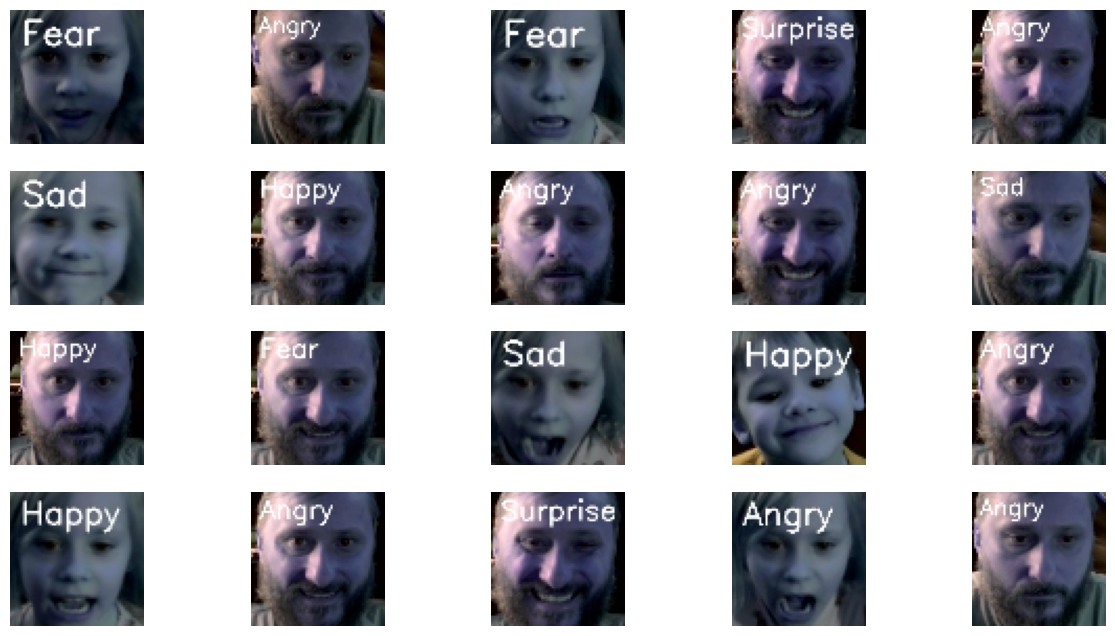

In [35]:
def plot_image_grid(images, ncols=None, cmap='gray', N=20):
    '''Plot a grid of images without emotion labels'''
    # Check if images is empty or has fewer elements than N
    if images.size == 0 or images.shape[0] < N:
        N = images.shape[0] # Adjust N to the number of available images
        if N == 0: # If images is empty, skip the rest of the function
            print("No images to display.")
            return
    
    # Ensure images is a 1-dimensional array of indices
    indices = np.arange(images.shape[0])
    selected_indices = np.random.choice(indices, size=N, replace=False)
    
    if not ncols:
        factors = [i for i in range(1, len(selected_indices)+1) if len(selected_indices) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(selected_indices) // 4 + 1
    nrows = int(len(selected_indices) / ncols) + int(len(selected_indices) % ncols)
    imgs = [images[i] if len(images) > i else None for i in selected_indices]
    f, axes = pyplot.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)
            ax.axis('off') # Hide axes
    pyplot.show()


plot_image_grid(emotion_images_np)
